In [13]:
from sim import Simulator, SimConfig
from miners.repay_proportional import RepayProportionalShortfallMinerState
from miners.burn import BurnShortfallMinerState
from miners.repay_ratchet import RepayRatchetShortfallMinerState
from network import *
from strategy import *
from consts import *

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd

network = dataclasses.replace(MAINNET_APR_2023,
    token_lease_fee=0.20,
    reward_decay=REWARD_DECAY, # or try REWARD_DECAY + BASELINE_GROWTH
)
epochs = 3 * YEAR + 1
stats_interval = DAY

In [14]:
def show_miner_accounting_charts(df):
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(13.4, 4.8))

    # Balance sheet
    ax1.grid(axis='y', color='#EEE')
    ax1.plot(df['day'], df['net_equity'], label="Net equity")
    ax1.plot(df['day'], df['balance'], label="Balance")
    ax1.plot(df['day'], df['available'], '--', label="Available")
    ax1.plot(df['day'], -df['lease'], label="Lease")
    ax1.plot(df['day'], df['pledge_locked'], '--', label="Pledge locked")
    ax1.set_title("Miner equity")
    ax1.set_xlabel("Day")
    ax1.set_ylabel("FIL")
    ax1.legend()

    # PnL
    ax2.grid(axis='y', color='#EEE')
    ax2.plot(df['day'], df['reward_earned'], label="Rewards")
    ax2.plot(df['day'], -df['fee_burned'], label="Shortfall fee")
    ax2.plot(df['day'], -df['lease_fee_accrued'], label="Lease fee")
    ax2.set_title("Miner cash flow")
    ax2.set_xlabel("Day")
    ax2.legend()

    plt.show()

def compare_configurations(cfgs, title):
    statss = {label: pd.DataFrame(Simulator(cfg).run_all(epochs, stats_interval)) for (label, cfg) in cfgs.items()}

    plt.grid(axis='y', color='#EEE')
    for label, df in statss.items():
        plt.plot(df['day'], df['net_equity'], label=label)

    plt.plot()
    plt.title("Miner equity - " + title)
    plt.xlabel("Day")
    plt.ylabel("FIL")
    plt.legend()
    plt.show()

## Repay the shortfall

In [15]:
repay_miner_factory = RepayRatchetShortfallMinerState.factory(
    balance=0,
    max_repayment_term=3 * YEAR,
    max_fee_reward_fraction=0.25,
    reward_projection_decay=REWARD_DECAY + BASELINE_GROWTH
)
cfg = SimConfig(
    network=network,
    strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
    miner_factory=repay_miner_factory,
)
stats = Simulator(cfg).run_all(epochs, stats_interval)
repay_shortfall_df = pd.DataFrame(data=stats)
repay_shortfall_df

,day,epoch,power,balance,lease,pledge_locked,available,net_equity,reward_earned,fee_burned,lease_fee_accrued,pledge_required,shortfall,shortfall_pct
0,0,1,252853314650112,1000.0000,1000.0002,1000.0000,0.0000,-0.0002,0.0000,0.0000,0.0002,1598.0184,598.0184,37.42
1,1,2881,252853314650112,1002.0424,1000.5466,1002.0424,0.0000,1.4958,2.7238,0.6798,0.5483,1598.0184,595.9759,37.29
2,2,5761,252853314650112,1004.0842,1001.0912,1004.0842,0.0000,2.9930,5.4468,1.3572,1.0967,1598.0184,593.9342,37.17
3,3,8641,252853314650112,1006.1253,1001.6340,1006.1253,0.0000,4.4913,8.1690,2.0323,1.6454,1598.0184,591.8930,37.04
4,4,11521,252853314650112,1008.1658,1002.1750,1008.1658,0.0000,5.9908,10.8902,2.7051,2.1944,1598.0184,589.8525,36.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,1091,3142081,252853314650112,2067.3819,0.0000,1598.0184,469.3635,2067.3819,2513.3274,102.8993,343.0461,1598.0184,0.0000,0.00
1092,1092,3144961,252853314650112,2069.3104,0.0000,1598.0184,471.2920,2069.3104,2515.2558,102.8993,343.0461,1598.0184,0.0000,0.00
1093,1093,3147841,252853314650112,2071.2383,0.0000,1598.0184,473.2199,2071.2383,2517.1837,102.8993,343.0461,1598.0184,0.0000,0.00
1094,1094,3150721,252853314650112,2073.1655,0.0000,1598.0184,475.1472,2073.1655,2519.1110,102.8993,343.0461,1598.0184,0.0000,0.00


<Figure size 640x480 with 0 Axes>

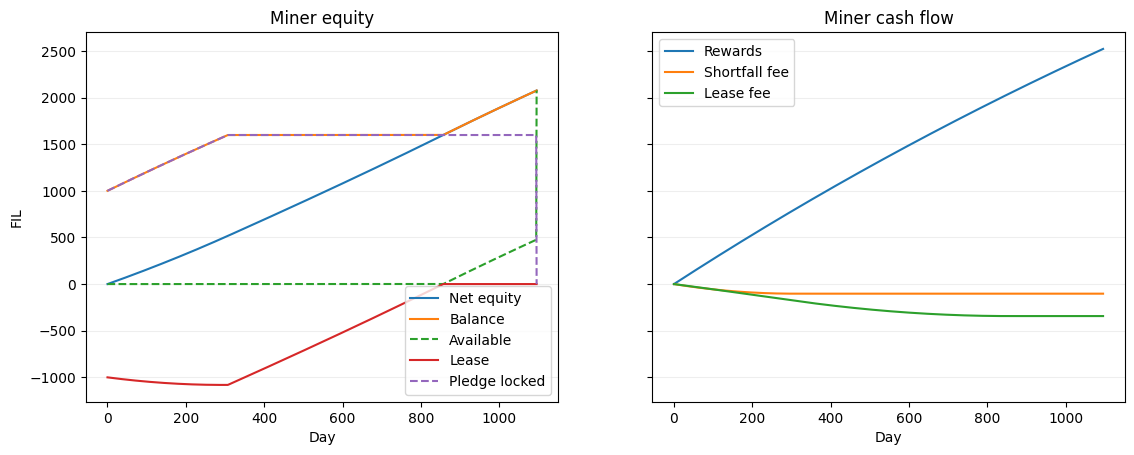

In [11]:
show_miner_accounting_charts(repay_shortfall_df)

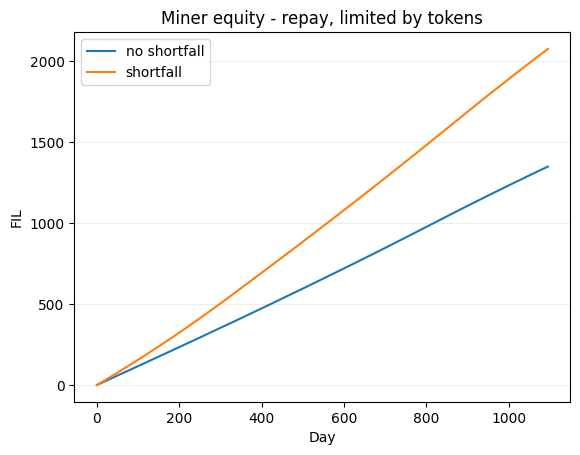

In [5]:
# Configurations limited by token availability.
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, False),
        miner_factory=repay_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
        miner_factory=repay_miner_factory,
    )
}, 'repay, limited by tokens')

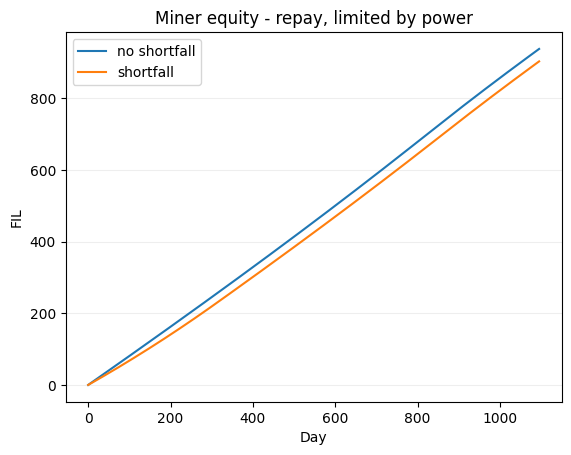

In [6]:
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100*TIBIBYTE, 3*YEAR, False),
        miner_factory=repay_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100*TIBIBYTE, 3*YEAR, True),
        miner_factory=repay_miner_factory,
    )
}, 'repay, limited by power')

## Burn the shortfall

In [7]:
burn_miner_factory = BurnShortfallMinerState.factory(balance=0)
cfg = SimConfig(
    network=network,
    strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
    miner_factory=burn_miner_factory,
)
stats = Simulator(cfg).run_all(epochs, stats_interval)
burn_shortfall_df = pd.DataFrame(data=stats)
burn_shortfall_df


,day,epoch,power,balance,lease,pledge_locked,available,net_equity,reward_earned,fee_burned,lease_fee_accrued,fee_pending
0,0,1,316453190369280,1000.0000,1000.0002,1000.0,0.0000,-0.0002,0.0000,0.0000,0.0002,999.9659
1,1,2881,316453190369280,1000.0000,999.6947,1000.0,0.0000,0.3053,3.4090,2.5556,0.5481,997.4103
2,2,5761,316453190369280,1000.0000,999.3871,1000.0,0.0000,0.6129,6.8169,5.1082,1.0957,994.8577
3,3,8641,316453190369280,1000.0000,999.0774,1000.0,0.0000,0.9226,10.2237,7.6578,1.6433,992.3081
4,4,11521,316453190369280,1000.0000,998.7657,1000.0,0.0000,1.2343,13.6294,10.2045,2.1906,989.7614
...,...,...,...,...,...,...,...,...,...,...,...,...
1091,1091,3142081,316453190369280,1902.7765,0.0000,1000.0,902.7765,1902.7765,3145.5014,990.9618,251.7631,9.0041
1092,1092,3144961,316453190369280,1905.1472,0.0000,1000.0,905.1472,1905.1472,3147.9150,991.0046,251.7631,8.9613
1093,1093,3147841,316453190369280,1907.5175,0.0000,1000.0,907.5175,1907.5175,3150.3278,991.0472,251.7631,8.9187
1094,1094,3150721,316453190369280,1909.8871,0.0000,1000.0,909.8871,1909.8871,3152.7398,991.0895,251.7631,8.8764


<Figure size 640x480 with 0 Axes>

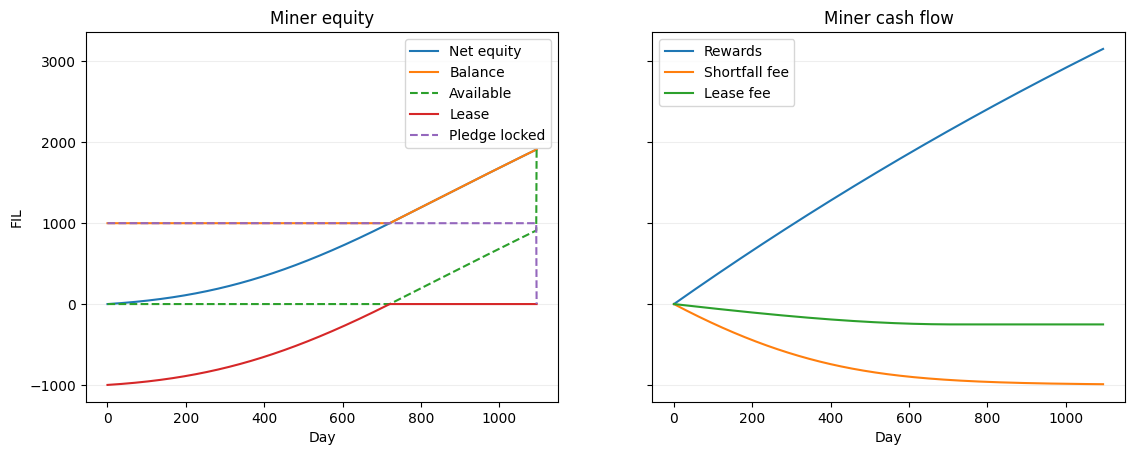

In [8]:
show_miner_accounting_charts(burn_shortfall_df)

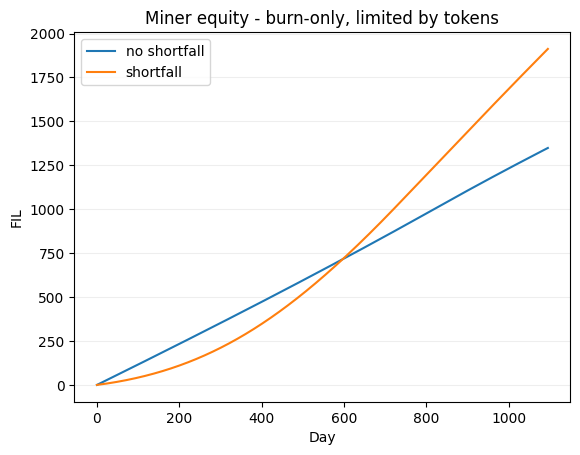

In [9]:
# Configurations limited by token availability.
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, False),
        miner_factory=burn_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
        miner_factory=burn_miner_factory,
    )
}, 'burn-only, limited by tokens')


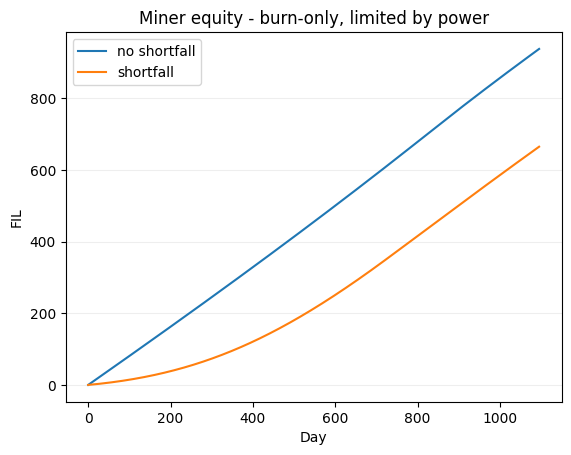

In [10]:
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100 * TIBIBYTE, 3 * YEAR, False),
        miner_factory=burn_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100 * TIBIBYTE, 3 * YEAR, True),
        miner_factory=burn_miner_factory,
    )
}, 'burn-only, limited by power')
